<a href="https://colab.research.google.com/github/JuanRosales707/LAB_ROSALES_11/blob/main/lab_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis

In [4]:
URL = "https://drive.google.com/file/d/1Gn2_7CGAX0D0M3Ka3JKSjlEdrWbKCxH0/view?usp=sharing"
URL = 'https://drive.google.com/uc?id=' + URL.split('/')[-2]


In [11]:
df = pd.read_csv(URL)
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


### **a. Realice el preprocesamiento de la información que incluya el análisis de datos faltantes,  tratamiento de outliers a nivel univariado y multivariado y escalamiento de datos para las  variables numéricas.**

In [13]:
# Análisis de datos faltantes
print("Datos faltantes por columna:")
print(df.isnull().sum())

Datos faltantes por columna:
TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64


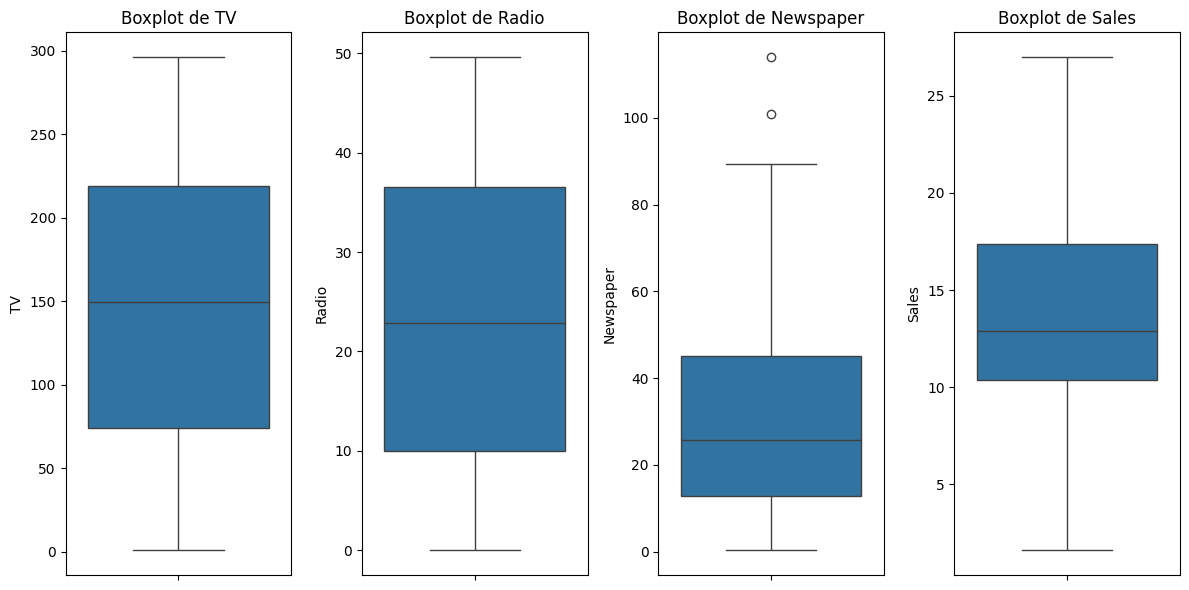

In [14]:
# Análisis de outliers univariados con boxplots
plt.figure(figsize=(12, 6))
for i, column in enumerate(df.columns):
    plt.subplot(1, 4, i+1)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot de {column}')
plt.tight_layout()
plt.show()

In [15]:
# Función para detectar outliers univariados con IQR
def detectar_outliers_univariados(df):
    outliers = {}
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        outliers[col] = df[(df[col] < limite_inferior) | (df[col] > limite_superior)].index.tolist()
    return outliers

outliers_univariados = detectar_outliers_univariados(df)
print("Outliers univariados:")
print(outliers_univariados)

Outliers univariados:
{'TV': [], 'Radio': [], 'Newspaper': [16, 101], 'Sales': []}


In [16]:
# Función para detectar outliers multivariados con distancia de Mahalanobis
def detectar_outliers_multivariados(df, threshold=3):
    datos = df.values
    media = np.mean(datos, axis=0)
    covarianza = np.cov(datos.T)
    inv_cov = np.linalg.inv(covarianza)
    distancias = [mahalanobis(row, media, inv_cov) for row in datos]
    return np.where(np.array(distancias) > threshold)[0]

outliers_multivariados = detectar_outliers_multivariados(df)
print("Outliers multivariados (Mahalanobis):")
print(outliers_multivariados)

Outliers multivariados (Mahalanobis):
[  2   5  16  35  75 101 126 128 130 165 178]


In [17]:
# Escalamiento de variables numéricas
scaler = StandardScaler()
df_escalado = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

print("Primeras filas del DataFrame escalado:")
print(df_escalado.head())

Primeras filas del DataFrame escalado:
         TV     Radio  Newspaper     Sales
0  0.969852  0.981522   1.778945  1.552053
1 -1.197376  1.082808   0.669579 -0.696046
2 -1.516155  1.528463   1.783549 -0.907406
3  0.052050  1.217855   1.286405  0.860330
4  0.394182 -0.841614   1.281802 -0.215683


### **b. Cree un algoritmo genético para seleccionar las mejores variables para un modelo de regresión  lineal incluyendo diversos valores para los parámetros: tamaño de la población, probabilidad  de cruce, probabilidad de mutación y número de generaciones.**

In [18]:
import random
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [19]:
# Variables disponibles
variables = ['TV', 'Radio', 'Newspaper']
X = df[variables]
y = df['Sales']

In [20]:
# Parámetros del algoritmo genético
tam_poblacion = 10
prob_cruce = 0.8
prob_mutacion = 0.1
num_generaciones = 20

In [21]:
# Función de evaluación
def evaluar(individuo):
    seleccionadas = [variables[i] for i in range(len(individuo)) if individuo[i] == 1]
    if len(seleccionadas) == 0:
        return 0
    modelo = LinearRegression()
    scores = cross_val_score(modelo, X[seleccionadas], y, cv=5, scoring='r2')
    return np.mean(scores)

def crear_individuo():
    return [random.choice([0, 1]) for _ in variables]

def cruzar(padre1, padre2):
    punto = random.randint(1, len(padre1) - 1)
    hijo1 = padre1[:punto] + padre2[punto:]
    hijo2 = padre2[:punto] + padre1[punto:]
    return hijo1, hijo2

# Mutación
def mutar(individuo):
    for i in range(len(individuo)):
        if random.random() < prob_mutacion:
            individuo[i] = 1 - individuo[i]
    return individuo

# Inicializar población
poblacion = [crear_individuo() for _ in range(tam_poblacion)]


In [22]:
# Algoritmo genético principal
mejor_individuo = None
mejor_puntaje = -np.inf

for generacion in range(num_generaciones):
    puntajes = [evaluar(ind) for ind in poblacion]

    max_index = np.argmax(puntajes)
    if puntajes[max_index] > mejor_puntaje:
        mejor_puntaje = puntajes[max_index]
        mejor_individuo = poblacion[max_index]

    padres = [poblacion[i] for i in np.argsort(puntajes)[-tam_poblacion//2:]]

    nueva_poblacion = []
    while len(nueva_poblacion) < tam_poblacion:
        padre1, padre2 = random.sample(padres, 2)
        if random.random() < prob_cruce:
            hijo1, hijo2 = cruzar(padre1, padre2)
        else:
            hijo1, hijo2 = padre1[:], padre2[:]
        nueva_poblacion.extend([mutar(hijo1), mutar(hijo2)])

    poblacion = nueva_poblacion[:tam_poblacion]

In [23]:
# Resultado final
mejores_variables = [variables[i] for i in range(len(variables)) if mejor_individuo[i] == 1]
print("Mejores variables seleccionadas:", mejores_variables)
print("Mejor score R² promedio:", round(mejor_puntaje, 4))

Mejores variables seleccionadas: ['TV', 'Radio']
Mejor score R² promedio: 0.8893


### **c. Realice un gráfico de la evolución del coeficiente de determinación (R2), seleccione las mejores  variables, cree un modelo de regresión lineal con base a estas tomando un 80% de datos para  el entrenamiento y mida su desempeño con el R2.**

In [24]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [25]:
# Guardar evolución del R² en cada generación
evolucion_r2 = []

In [26]:
# Reiniciar población
poblacion = [crear_individuo() for _ in range(tam_poblacion)]
mejor_individuo = None
mejor_puntaje = -np.inf

for generacion in range(num_generaciones):
    puntajes = [evaluar(ind) for ind in poblacion]
    evolucion_r2.append(max(puntajes))
    max_index = np.argmax(puntajes)
    if puntajes[max_index] > mejor_puntaje:
        mejor_puntaje = puntajes[max_index]
        mejor_individuo = poblacion[max_index]

    padres = [poblacion[i] for i in np.argsort(puntajes)[-tam_poblacion//2:]]
    nueva_poblacion = []
    while len(nueva_poblacion) < tam_poblacion:
        padre1, padre2 = random.sample(padres, 2)
        if random.random() < prob_cruce:
            hijo1, hijo2 = cruzar(padre1, padre2)
        else:
            hijo1, hijo2 = padre1[:], padre2[:]
        nueva_poblacion.extend([mutar(hijo1), mutar(hijo2)])
    poblacion = nueva_poblacion[:tam_poblacion]

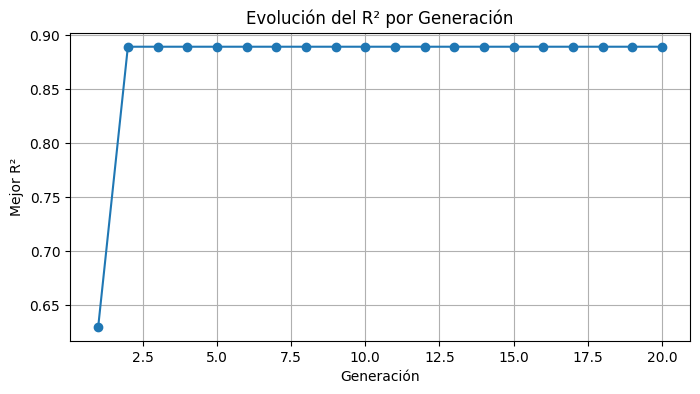

In [27]:
# Gráfico de evolución del R²
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_generaciones + 1), evolucion_r2, marker='o')
plt.title("Evolución del R² por Generación")
plt.xlabel("Generación")
plt.ylabel("Mejor R²")
plt.grid(True)
plt.show()

In [28]:

# Selección de las mejores variables
mejores_variables = [variables[i] for i in range(len(variables)) if mejor_individuo[i] == 1]
print("Mejores variables seleccionadas:", mejores_variables)

Mejores variables seleccionadas: ['TV', 'Radio']


In [29]:
# Modelo de regresión lineal y evaluación con 80/20 split
X_final = df[mejores_variables]
y_final = df['Sales']

In [30]:
# División 80/20
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# Entrenar modelo
modelo_final = LinearRegression()
modelo_final.fit(X_train, y_train)

# Predecir y calcular R²
y_pred = modelo_final.predict(X_test)
r2_final = r2_score(y_test, y_pred)

print(f"R² en el conjunto de prueba: {round(r2_final, 4)}")

R² en el conjunto de prueba: 0.9006
